In [29]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from src.ExportModel import ExportModel
from pathlib import Path
import numpy as np

model_path = "sound_instructions.keras"
audio_model = tf.keras.models.load_model(model_path)
audio_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,876,829 (18.60 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 3,251,218 (12.40 MB)

In [2]:
last_layer_name = audio_model.layers[-1].name
feature_output = audio_model.get_layer(last_layer_name).output
feature_output

<KerasTensor shape=(None, 8), dtype=float32, sparse=False, ragged=False, name=keras_tensor_54>

In [3]:
audio_model.inputs

[<KerasTensor shape=(None, 124, 129, 1), dtype=float32, sparse=False, ragged=False, name=input_layer>]

In [4]:
base_model = Model(inputs=audio_model.inputs, outputs=feature_output)

In [5]:
# DATASET

In [6]:
alarm_data = Path('DataMutated')

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=alarm_data,
    batch_size=8,
    validation_split=0.3,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 56 files belonging to 1 classes.
Using 40 files for training.
Using 16 files for validation.

label names: ['alarm']


In [12]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import librosa
tf.__version__

'2.20.0'

In [14]:
def load_wav_16k_mono(filename):
    audio, _ = librosa.load(filename, sr=16000, mono=True)
    audio = tf.convert_to_tensor(audio, dtype=tf.float32)
    return audio

In [9]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

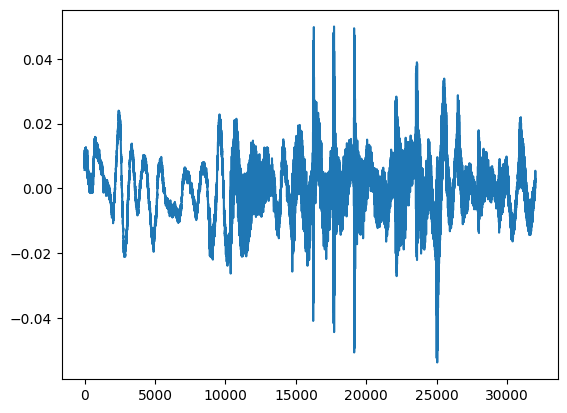

In [26]:
test_alarm = Path('DataMutated') / Path('alarm') / Path('Boosted_alarm0_0_x1.98.wav')
testing_wav_data = load_wav_16k_mono(test_alarm)

_ = plt.plot(testing_wav_data)
display.Audio(testing_wav_data, rate=16000)


In [27]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [28]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')


The main sound is: Animal
The embeddings shape: (4, 1024)


In [42]:
import tensorflow as tf
import numpy as np

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

label_names= ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']


class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # You could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If a string is passed, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [43]:
MODEL_PATH = "sound_instructions.keras"
audio_model = tf.keras.models.load_model(MODEL_PATH)

In [44]:
test_clip = Path("data")/Path("mini_speech_commands_extracted")/Path("mini_speech_commands")/Path("down")/Path("d0faf7e4_nohash_0.wav")
export = ExportModel(audio_model)
result = export(tf.constant(str(test_clip)))
result

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 12.48638 ,   9.848174, -13.00735 ,   8.832891,  -8.849454,
          -3.387131, -11.520782, -11.484932]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'down'], dtype=object)>}

In [45]:
class_name = result['class_names'].numpy()[0].decode('utf-8')

print(class_name)

down


In [48]:
import tensorflow as tf
import os
import pathlib
from pathlib import Path
import soundfile as sf
import numpy as np

DATASET_PATH = Path('data/mini_speech_commands_extracted/mini_speech_commands')
SILENCE_PATH = DATASET_PATH / "silence"

SPEECH_COMMANDS_PATH = Path("data/full_speech_commands/speech_commands_v0_extracted")
BG_NOISE_PATH = SPEECH_COMMANDS_PATH / "_background_noise_"

if not BG_NOISE_PATH.exists():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
    tf.keras.utils.get_file(
        'speech_commands_v0.02.tar.gz',
        url,
        cache_dir='.',
        cache_subdir='data/full_speech_commands',
        extract=True
    )

if not SILENCE_PATH.exists():
    os.makedirs(SILENCE_PATH)

In [52]:
# chop noise files into 1-second clips.
cnt = 0
TARGET_SAMPLE_RATE = 16000
SAMPLES_PER_CLIP = 16000 

files = [f for f in os.listdir(BG_NOISE_PATH) if f.endswith('.wav')]

for file_name in files:
    file_path = BG_NOISE_PATH / file_name    
    audio, sr = sf.read(file_path)
    
    if sr != TARGET_SAMPLE_RATE:
        print(f"Skipping {file_name} due to sample rate mismatch {sr}")
        continue
        
    # Chop into 1-second chunks
    num_clips = len(audio) // SAMPLES_PER_CLIP
    
    for i in range(num_clips):
        start = i * SAMPLES_PER_CLIP
        end = start + SAMPLES_PER_CLIP
        clip = audio[start:end]
        
        # Save as a new file in the 'silence' folder
        factor = 0.8
        output_filename = SILENCE_PATH / f"silence_x{factor}_{cnt}.wav"
        sf.write(output_filename, clip * factor, TARGET_SAMPLE_RATE)
        cnt += 1

print(f"Done! Created {cnt} silence clips in {SILENCE_PATH}")

Done! Created 398 silence clips in data\mini_speech_commands_extracted\mini_speech_commands\silence


In [ ]:
go_path = DATASET_PATH / "go"
go_count = go_path